# SEASONAL FORECASTS: bias

## Use case: risk assessment in agriculture using seasonal forecasts of temperature and precipitation.

# Quality assessment questions
* Do I have to correct systematic errors in temperature and precipitation before using seasonal forecasts as an input for my crop model?
* Can I assume that climate models produce always the same systematic error for seasonal forecasts over a certain area? 

# Introduction

Seasonal forecasts are often employed as an input to crop models for risk assessment in agriculture (Rodriguez et al., 2018; Jha et al., 2019; Danielli et al., 2022). The presence of systematic errors may undermine the output of crop models in various ways, especially when critical thresholds for the growth process of plants are considered.

This notebook provides a comprehensive analysis of the bias of the forecasting systems by showing the systematic error for temperature and precipitation compared to the reanalysis ERA5. The analysis is conducted over the 8 regions indicated in the figure below, which are expected to capture the spatial scale of the main systematic errors already analyzed in previous studies (Manzanas et al., 2019## Quality assessment statement

* Seasonal forecasts for should be bias corrected before using them as an input for impact models.
* In particular the temperature and precipitation bias tends to be a function of both the starting time of the forecast and of its valid time, with a slighlty stronger dependence on the valid time, i.e. forecasts for a given month have normally a similar bias, regardless of the starting date of the forecast
* It is recommended that reference climatologies are computed for time scales which are not longer than one month, since the typical model bias changes on a monthly basis. On the other hand, correcting the model biases on a seasonal (e.g. three months) time scale, may result into a loss of accuracy.
* Similarly, the computation of multi-model statistics requires a recalibration of the models' output in order to align al models around the same climatological distribution.

The figure below shows a sample map of the CMCC model bias for forecasts issued in January and valid for the first month of the forecast. 

  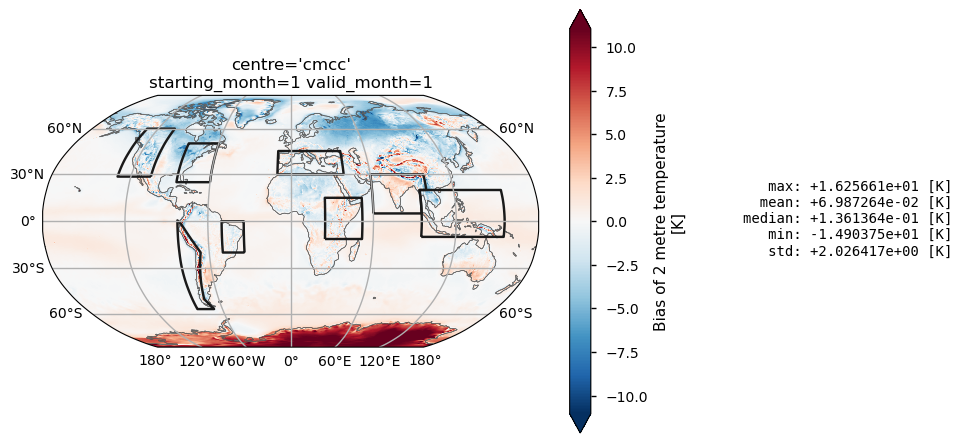t in order  

## Method

For each selected area, do the following steps.

1. Retrieve monthly ERA5 data and compute the regional mean climatology, i.e. 12 values for each area
2. Retrieve seasonal forecast data from all available centres and for all starting dates, compute the monthly mean climatology (i.e. 6 values, since each forecast is valid for 6 months) and subtract the corresponding ERA5 climatology.
3. Arrange data in a four dimensional array `bias[i,j,n,k]`, where:
> * `i` is the reference starting month of the forecast (from january to december)
> * `j` is the valid time of the forecast (from january to december)
> * `n` is the originating centre of the forecast (currently a maximum of 8)
> * `k` is the region (currently 7 has defined in the figure above)
4. Results are displayed in a comprehensive set of panels that provides an overview of the multimodel performance

### Import packages

We use the package `regionmask` to extract climatologies over a few selected areas that have been already adopted in several climate studies, including the analysis presented the latest IPCC reports.

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import regionmask
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot

plt.style.use("seaborn-v0_8-notebook")

## Define parameters

In this notebook the analysis of the model bias is done for 5 variables from all 8 originating centres. The SREX regions selected for the analysis are:

- EAF: Eastern Africa
- ENA: Eastern North America
- MED: Southern Europe/Mediterranean
- NEB: North-eastern Brazil
- SAS: Southern Asia
- SEA: South-Eastern Asia
- WNA: Western North America
- WSA: Western Coast of South America

In [5]:
# Time
year_start_hindcast = 1993
year_stop_hindcast = 2016

# Variable
variables = [
    "2m_temperature",
    "total_precipitation",
    "10m_wind_speed",
    "2m_dewpoint_temperature",
]

# Define centres with missing variables
missing_variables = {"eccc": ["2m_dewpoint_temperature"]}

# Centres
centres = {
    "cmcc": {"system": "35"},
    "dwd": {"system": "21"},
    "eccc": {"system": "3"},
    "ecmwf": {"system": "51"},
    "jma": {"system": "3"},
    "meteo_france": {"system": "8"},
    "ncep": {"system": "2"},
    "ukmo": {"system": "601"},
}
assert all("system" in v for v in centres.values())
assert set(centres) <= {
    "cmcc",
    "dwd",
    "eccc",
    "ecmwf",
    "jma",
    "meteo_france",
    "ncep",
    "ukmo",
}

# Regions
regions = [
    "EAF",
    "ENA",
    "MED",
    "NEB",
    "SAS",
    "SEA",
    "WNA",
    "WSA",
]
assert set(regions) <= set(regionmask.defined_regions.srex.abbrevs)

# Ploting settings
plot_kwargs = {
    "total_precipitation": {"cmap": "BrBG"},
}

## Plot selected regions
For the bias analysis we use 8 out of the 26 SREX regions defined by Seneviratne et al. (2012) in order to test the systematic errors of the modellings systems under different climatic regimes (tropics, extratropic, continental, maritime) with a number of cases that is maneageable within the notebook.

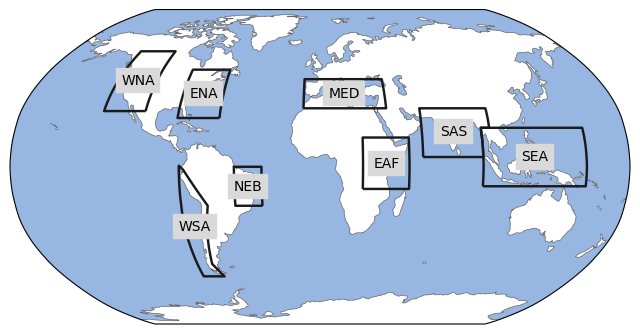

In [6]:
ax = regionmask.defined_regions.srex[regions].plot(
    projection=ccrs.Robinson(),
    label="abbrev",
    add_ocean=True,
)
ax.set_global()

### Define requests

A `common_request` is defined in order to cover the full global domain and the entire hindcast period from 1993 to 2016.
Specific data requests are then defined for the reanalysis and for the seasonal forecasts, so that all available months and leadtimes are retrieved for the analysi.s

In [7]:
chunks = {"year": 1, "variable": 1}
common_request = {
    "format": "grib",
    "area": [89.5, -179.5, -89.5, 179.5],
    "year": [str(year) for year in range(year_start_hindcast, year_stop_hindcast + 1)],
}

collection_id_reanalysis = "reanalysis-era5-single-levels-monthly-means"
request_reanalysis = common_request | {
    "product_type": "monthly_averaged_reanalysis",
    "month": [f"{month:02d}" for month in range(1, 13)],
    "time": "00:00",
}

collection_id_seasonal = "seasonal-monthly-single-levels"
request_seasonal = common_request | {
    "product_type": "monthly_mean",
    "leadtime_month": list(map(str, range(1, 7))),
    "month": [f"{month:02d}" for month in range(1, 13)],
    "grid": "1/1",
}

### Functions to cache

- The function `regionalised_spatial_weighted_mean` extracts the regional averages over the selected domains. It uses spatial weighting to account for the latitudinal dependence of the grid size in the lon-lat grids used for the reanalysis and for the forecast models. The bias is then computed below in the notebook by simply subtracting the regional means.. 

- The function `postprocess_dataarray` performs two key postprocessings required for the alignment of the arrays containing the reanalsysis and the forecast data. 

    - The time dimensions are renamed to allow the broadcasting of the dimension `valid_time`, which is used to compute the bias, regardless of the corresponding `leadtimes` in the forecast. 

    - Furthermore, accumulated variables need to be rescaled in order to make ERA5 data and seasonal forecast data comparable over a monthly timescale. A [conversion table](https://confluence.ecmwf.int/pages/viewpage.action?pageId=197702790)  for accumulated variables is available in the [Copernicus Knowledge Base](https://confluence.ecmwf.int/pages/viewpage.action?pageId=55116796) repository.

- The function `get_seasonal_maps` is used to derive a sample bias map for the purpose of illustrating how the analysi
- The function `monthly_mean` will be used to derive the monthly values at the appropriate `monthly_mean` before computing the bias.s works.

In [10]:
def regionalised_spatial_weighted_mean(ds, region, weights, mean_dims=None):
    mask = regionmask.defined_regions.srex.mask(ds)
    index = regionmask.defined_regions.srex.map_keys(region)
    ds = ds.where((mask == index).compute(), drop=True)
    ds = diagnostics.spatial_weighted_mean(ds, weights=weights)
    if mean_dims:
        return ds.mean(mean_dims, keep_attrs=True)
    return ds


def postprocess_dataarray(da):
    time_dims = {dim for dim in da.dims if "time" in dim}
    if time_dims:
        if len(time_dims) == 1:
            (valid_time,) = time_dims
        else:
            starting_time = "forecast_reference_time"
            (valid_time,) = time_dims - {starting_time}
            da = da.rename({starting_time: "starting_time"})
        da = da.rename({valid_time: "valid_time"})

    if "leadtime" in da.coords:
        da = da.drop_vars("leadtime")

    # Convert units
    m_to_mm = 1.0e3
    day_to_s = 60 * 60 * 24
    if da.name == "total_precipitation" and da.attrs["units"] != "mm/month":
        if da.attrs["units"] == "m":
            factor = m_to_mm
        elif da.attrs["units"] == "m s**-1":
            factor = m_to_mm * day_to_s
        else:
            raise ValueError(f"{da.attrs['units']=}")

        if "valid_time" in da.coords:
            factor *= da["valid_time"].dt.days_in_month
            units = "mm/month"
        else:
            units = "mm/day"
        with xr.set_options(keep_attrs=True):
            da *= factor
        da.attrs["units"] = units
    return da


def get_seasonal_map(ds, starting_month, valid_month, grid_out, **kwargs):
    starting_time = "forecast_reference_time"
    (valid_dim,) = {dim for dim in ds.dims if "time" in dim} - {starting_time}
    (year,) = set(ds[starting_time].dt.year.values)

    for dim, prefix in {starting_time: "starting", valid_dim: "valid"}.items():
        ds = (
            ds.groupby(f"{dim}.month")
            .mean(keep_attrs=True)
            .rename(month=f"{prefix}_month")
        )
    ds = ds.sel(starting_month=starting_month, valid_month=valid_month)
    ds = ds.mean("realization", keep_attrs=True)

    ds = diagnostics.regrid(ds, grid_out, **kwargs)
    return ds.expand_dims(year=[year])


def monthly_mean(ds):
    for dim in ds.dims:
        if "time" in dim:
            ds = (
                ds.groupby(f"{dim}.month")
                .mean(keep_attrs=True)
                .rename(month=dim.replace("time", "month"))
            )
    return ds

# Show a sample global map of temperature biases

To reduce computation, this notebook simplifies the bias analysis by focusing on mean values of surface variables across the chosen regions. The goal is to offer a broad overview of the bias evolution over lead times. Thus, it is crucial that the selected regions exhibit sufficient homogeneity to minimize the compensation effects from systematic errors of varying sign.

This section of the notebook offers a simple tool for exploring sample bias maps and confirming that bias sign remain relatively constant within selected regions. Additionally, it serves as an insight on the behavior of individual models summarized in the comprehensive tables provided later in the notebook.

100%|██████████| 24/24 [00:03<00:00,  6.47it/s]


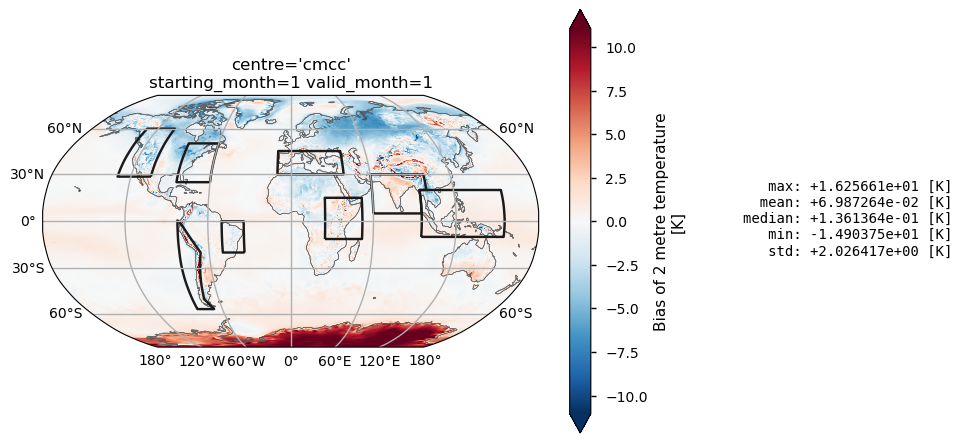

In [11]:
# Set parameters
variable = '2m_temperature'
leadtime_month = "1"
starting_month = 1
valid_month = 1
centre = "cmcc"
assert all(month in range(1, 13) for month in (starting_month, valid_month))
assert variable in variables
assert centre in centres

# Get reanalysis map
ds = download.download_and_transform(
    collection_id_reanalysis,
    request_reanalysis | {"variable": variable},
    chunks=chunks,
    transform_chunks=False,
    transform_func=diagnostics.monthly_weighted_mean,
)
ds = ds.rename(month="valid_month").sel(valid_month=valid_month)
grid_out = ds[["latitude", "longitude"]]
(da,) = ds.data_vars.values()
da_reanalysis = postprocess_dataarray(da.rename(variable))

# Get seasonal map
ds = download.download_and_transform(
    collection_id_seasonal,
    request_seasonal
    | {"originating_centre": centre, "variable": variable}
    | centres[centre],
    chunks=chunks,
    transform_func=get_seasonal_map,
    transform_func_kwargs={
        "starting_month": starting_month,
        "valid_month": valid_month,
        "grid_out": grid_out,
        "method": "bilinear",
    },
    backend_kwargs={
        "time_dims": (
            "verifying_time",
            ("indexing_time" if centre in ["ukmo", "jma", "ncep"] else "time"),
        )
    },
)
ds = ds.mean("year", keep_attrs=True)
(da,) = ds.data_vars.values()
da_seasonal = postprocess_dataarray(da.rename(variable))

# Compute bias
with xr.set_options(keep_attrs=True):
    bias = da_seasonal - da_reanalysis
bias.attrs["long_name"] = "Bias of " + bias.attrs["long_name"]

# Plot
plot.projected_map(
    bias, projection=ccrs.Robinson(), **plot_kwargs.get(variable, {}) | {"robust": True}
)
regionmask.defined_regions.srex[regions].plot(add_label=False)
_ = plt.title(f"{centre=}\n{starting_month=} {valid_month=}")

# Download and transform ERA5

The `regionalised_spatial_weighted_mean` is applied for all regions and all variables selected for download. All time series of the regionalised means are collected in the same xarray `ds_reanalysis`.

In [12]:
# Get the reanalysis data
datasets = []
for region in regions:
    dataarrays = []
    for variable in variables:
        print(f"{region=} {variable=}")
        ds = download.download_and_transform(
            collection_id_reanalysis,
            request_reanalysis | {"variable": variable},
            chunks=chunks,
            transform_func=regionalised_spatial_weighted_mean,
            transform_func_kwargs={"region": region, "weights": True},
        )
        (da,) = ds.data_vars.values()
        dataarrays.append(postprocess_dataarray(da.rename(variable)))
    ds = xr.merge(dataarrays)
    datasets.append(ds.expand_dims(region=[region]).compute())
ds_reanalysis = xr.concat(datasets, "region")
del datasets

#Compute monthly mean
ds_reanalysis = monthly_mean(ds_reanalysis)

region='EAF' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.67it/s]


region='EAF' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 12.84it/s]


region='EAF' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 13.61it/s]


region='EAF' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.25it/s]


region='ENA' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 14.30it/s]


region='ENA' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 14.14it/s]


region='ENA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 11.04it/s]


region='ENA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00, 10.97it/s]


region='MED' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00, 10.06it/s]


region='MED' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00, 11.01it/s]


region='MED' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 11.51it/s]


region='MED' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00, 10.50it/s]


region='NEB' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00,  9.54it/s]


region='NEB' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00, 11.96it/s]


region='NEB' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 11.55it/s]


region='NEB' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.08it/s]


region='SAS' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00,  9.70it/s]


region='SAS' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00,  8.49it/s]


region='SAS' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00,  9.31it/s]


region='SAS' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00,  8.87it/s]


region='SEA' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.72it/s]


region='SEA' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00,  9.55it/s]


region='SEA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 12.61it/s]


region='SEA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.07it/s]


region='WNA' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.98it/s]


region='WNA' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00, 11.02it/s]


region='WNA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 12.20it/s]


region='WNA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.40it/s]


region='WSA' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00, 10.15it/s]


region='WSA' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00, 10.83it/s]


region='WSA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 10.49it/s]


region='WSA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.11it/s]


# Download and transform seasonal forecast

The `regionalised_spatial_weighted_mean` is applied for all centres, regions and all variables selected for download. Missing variables are handled, so the download and transform process is not interrupted. All time series of the regionalised means are collected in the same xarray `ds_seasonal`.

In [13]:
# Get the seasonal forecast data
datasets = []
for centre, request_kwargs in centres.items():
    for region in regions:
        dataarrays = []
        for variable in variables:
            print(f"{centre=} {region=} {variable=}")
            if variable in missing_variables.get(centre, []):
                print("SKIP")
                continue

            ds = download.download_and_transform(
                collection_id_seasonal,
                request_seasonal
                | {"originating_centre": centre, "variable": variable}
                | request_kwargs,
                chunks=chunks,
                transform_func=regionalised_spatial_weighted_mean,
                transform_func_kwargs={
                    "region": region,
                    "weights": True,
                    "mean_dims": ("realization",),
                },
                backend_kwargs={
                    "time_dims": (
                        "verifying_time",
                        (
                            "indexing_time"
                            if centre in ["ukmo", "jma", "ncep"]
                            else "time"
                        ),
                    )
                },
            )
            (da,) = ds.data_vars.values()
            dataarrays.append(postprocess_dataarray(da.rename(variable)))
        ds = xr.merge(dataarrays)
        datasets.append(ds.expand_dims(centre=[centre], region=[region]).compute())
ds_seasonal = xr.merge(datasets)
del datasets

#Compute monthly mean
ds_seasonal = monthly_mean(ds_seasonal)

centre='cmcc' region='EAF' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00,  9.24it/s]


centre='cmcc' region='EAF' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 12.38it/s]


centre='cmcc' region='EAF' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 10.28it/s]


centre='cmcc' region='EAF' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.65it/s]


centre='cmcc' region='ENA' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00, 10.67it/s]


centre='cmcc' region='ENA' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 13.22it/s]


centre='cmcc' region='ENA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 11.29it/s]


centre='cmcc' region='ENA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.62it/s]


centre='cmcc' region='MED' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.31it/s]


centre='cmcc' region='MED' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 12.73it/s]


centre='cmcc' region='MED' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 11.04it/s]


centre='cmcc' region='MED' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.89it/s]


centre='cmcc' region='NEB' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00,  8.87it/s]


centre='cmcc' region='NEB' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00, 11.32it/s]


centre='cmcc' region='NEB' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 10.04it/s]


centre='cmcc' region='NEB' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:03<00:00,  7.28it/s]


centre='cmcc' region='SAS' variable='2m_temperature'


100%|██████████| 24/24 [00:03<00:00,  7.12it/s]


centre='cmcc' region='SAS' variable='total_precipitation'


100%|██████████| 24/24 [00:07<00:00,  3.25it/s]


centre='cmcc' region='SAS' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 11.04it/s]


centre='cmcc' region='SAS' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00, 10.96it/s]


centre='cmcc' region='SEA' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00, 10.35it/s]


centre='cmcc' region='SEA' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00, 10.31it/s]


centre='cmcc' region='SEA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 11.96it/s]


centre='cmcc' region='SEA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


centre='cmcc' region='WNA' variable='2m_temperature'


100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


centre='cmcc' region='WNA' variable='total_precipitation'


100%|██████████| 24/24 [00:03<00:00,  6.84it/s]


centre='cmcc' region='WNA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 10.95it/s]


centre='cmcc' region='WNA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00,  9.89it/s]


centre='cmcc' region='WSA' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.32it/s]


centre='cmcc' region='WSA' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 12.19it/s]


centre='cmcc' region='WSA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 12.59it/s]


centre='cmcc' region='WSA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.30it/s]


centre='dwd' region='EAF' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00, 10.80it/s]


centre='dwd' region='EAF' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 12.06it/s]


centre='dwd' region='EAF' variable='10m_wind_speed'


100%|██████████| 24/24 [00:03<00:00,  7.04it/s]


centre='dwd' region='EAF' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00, 10.51it/s]


centre='dwd' region='ENA' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.59it/s]


centre='dwd' region='ENA' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 12.33it/s]


centre='dwd' region='ENA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 11.58it/s]


centre='dwd' region='ENA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.15it/s]


centre='dwd' region='MED' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.48it/s]


centre='dwd' region='MED' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00, 11.58it/s]


centre='dwd' region='MED' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 12.76it/s]


centre='dwd' region='MED' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.60it/s]


centre='dwd' region='NEB' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.07it/s]


centre='dwd' region='NEB' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 12.47it/s]


centre='dwd' region='NEB' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 10.54it/s]


centre='dwd' region='NEB' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00,  9.85it/s]


centre='dwd' region='SAS' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.56it/s]


centre='dwd' region='SAS' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 12.16it/s]


centre='dwd' region='SAS' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 12.82it/s]


centre='dwd' region='SAS' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00,  9.08it/s]


centre='dwd' region='SEA' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00,  9.29it/s]


centre='dwd' region='SEA' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00,  8.63it/s]


centre='dwd' region='SEA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 11.16it/s]


centre='dwd' region='SEA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.05it/s]


centre='dwd' region='WNA' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.12it/s]


centre='dwd' region='WNA' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 12.49it/s]


centre='dwd' region='WNA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 11.43it/s]


centre='dwd' region='WNA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.78it/s]


centre='dwd' region='WSA' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.07it/s]


centre='dwd' region='WSA' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 13.19it/s]


centre='dwd' region='WSA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 11.33it/s]


centre='dwd' region='WSA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.21it/s]


centre='eccc' region='EAF' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.07it/s]


centre='eccc' region='EAF' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00, 11.49it/s]


centre='eccc' region='EAF' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 12.43it/s]


centre='eccc' region='EAF' variable='2m_dewpoint_temperature'
SKIP
centre='eccc' region='ENA' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.97it/s]


centre='eccc' region='ENA' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00, 11.96it/s]


centre='eccc' region='ENA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 11.29it/s]


centre='eccc' region='ENA' variable='2m_dewpoint_temperature'
SKIP
centre='eccc' region='MED' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.44it/s]


centre='eccc' region='MED' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00, 10.83it/s]


centre='eccc' region='MED' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00,  9.15it/s]


centre='eccc' region='MED' variable='2m_dewpoint_temperature'
SKIP
centre='eccc' region='NEB' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.75it/s]


centre='eccc' region='NEB' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 12.50it/s]


centre='eccc' region='NEB' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 10.56it/s]


centre='eccc' region='NEB' variable='2m_dewpoint_temperature'
SKIP
centre='eccc' region='SAS' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00,  9.69it/s]


centre='eccc' region='SAS' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00, 11.69it/s]


centre='eccc' region='SAS' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 11.42it/s]


centre='eccc' region='SAS' variable='2m_dewpoint_temperature'
SKIP
centre='eccc' region='SEA' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00,  9.42it/s]


centre='eccc' region='SEA' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 12.29it/s]


centre='eccc' region='SEA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 11.66it/s]


centre='eccc' region='SEA' variable='2m_dewpoint_temperature'
SKIP
centre='eccc' region='WNA' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 14.71it/s]


centre='eccc' region='WNA' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 13.62it/s]


centre='eccc' region='WNA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 12.03it/s]


centre='eccc' region='WNA' variable='2m_dewpoint_temperature'
SKIP
centre='eccc' region='WSA' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.79it/s]


centre='eccc' region='WSA' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00, 11.63it/s]


centre='eccc' region='WSA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 13.60it/s]


centre='eccc' region='WSA' variable='2m_dewpoint_temperature'
SKIP
centre='ecmwf' region='EAF' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.24it/s]


centre='ecmwf' region='EAF' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 13.22it/s]


centre='ecmwf' region='EAF' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 12.82it/s]


centre='ecmwf' region='EAF' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.24it/s]


centre='ecmwf' region='ENA' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00, 10.67it/s]


centre='ecmwf' region='ENA' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00, 11.60it/s]


centre='ecmwf' region='ENA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 12.38it/s]


centre='ecmwf' region='ENA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00, 10.56it/s]


centre='ecmwf' region='MED' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.75it/s]


centre='ecmwf' region='MED' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 12.73it/s]


centre='ecmwf' region='MED' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 11.57it/s]


centre='ecmwf' region='MED' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 14.35it/s]


centre='ecmwf' region='NEB' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.44it/s]


centre='ecmwf' region='NEB' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00, 11.33it/s]


centre='ecmwf' region='NEB' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 11.88it/s]


centre='ecmwf' region='NEB' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.26it/s]


centre='ecmwf' region='SAS' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 14.20it/s]


centre='ecmwf' region='SAS' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 12.45it/s]


centre='ecmwf' region='SAS' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 13.67it/s]


centre='ecmwf' region='SAS' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.69it/s]


centre='ecmwf' region='SEA' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.74it/s]


centre='ecmwf' region='SEA' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 12.68it/s]


centre='ecmwf' region='SEA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 12.74it/s]


centre='ecmwf' region='SEA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 14.10it/s]


centre='ecmwf' region='WNA' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.96it/s]


centre='ecmwf' region='WNA' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00, 11.56it/s]


centre='ecmwf' region='WNA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 12.39it/s]


centre='ecmwf' region='WNA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.25it/s]


centre='ecmwf' region='WSA' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.80it/s]


centre='ecmwf' region='WSA' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 13.84it/s]


centre='ecmwf' region='WSA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 11.96it/s]


centre='ecmwf' region='WSA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.51it/s]


centre='jma' region='EAF' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.23it/s]


centre='jma' region='EAF' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 12.72it/s]


centre='jma' region='EAF' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 13.34it/s]


centre='jma' region='EAF' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.50it/s]


centre='jma' region='ENA' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.87it/s]


centre='jma' region='ENA' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00, 10.71it/s]


centre='jma' region='ENA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 13.19it/s]


centre='jma' region='ENA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.93it/s]


centre='jma' region='MED' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.13it/s]


centre='jma' region='MED' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00, 11.35it/s]


centre='jma' region='MED' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 11.45it/s]


centre='jma' region='MED' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.75it/s]


centre='jma' region='NEB' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.33it/s]


centre='jma' region='NEB' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 13.52it/s]


centre='jma' region='NEB' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 12.68it/s]


centre='jma' region='NEB' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.32it/s]


centre='jma' region='SAS' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.72it/s]


centre='jma' region='SAS' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00,  9.71it/s]


centre='jma' region='SAS' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 12.76it/s]


centre='jma' region='SAS' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00, 10.52it/s]


centre='jma' region='SEA' variable='2m_temperature'


100%|██████████| 24/24 [00:03<00:00,  6.88it/s]


centre='jma' region='SEA' variable='total_precipitation'


100%|██████████| 24/24 [00:04<00:00,  5.37it/s]


centre='jma' region='SEA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:03<00:00,  6.16it/s]


centre='jma' region='SEA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:03<00:00,  7.38it/s]


centre='jma' region='WNA' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.41it/s]


centre='jma' region='WNA' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 13.96it/s]


centre='jma' region='WNA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 12.42it/s]


centre='jma' region='WNA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.81it/s]


centre='jma' region='WSA' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.32it/s]


centre='jma' region='WSA' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 12.62it/s]


centre='jma' region='WSA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 12.14it/s]


centre='jma' region='WSA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.90it/s]


centre='meteo_france' region='EAF' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.24it/s]


centre='meteo_france' region='EAF' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 12.59it/s]


centre='meteo_france' region='EAF' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 13.18it/s]


centre='meteo_france' region='EAF' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00, 10.62it/s]


centre='meteo_france' region='ENA' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00, 10.03it/s]


centre='meteo_france' region='ENA' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 13.03it/s]


centre='meteo_france' region='ENA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 12.18it/s]


centre='meteo_france' region='ENA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.11it/s]


centre='meteo_france' region='MED' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.56it/s]


centre='meteo_france' region='MED' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00, 11.45it/s]


centre='meteo_france' region='MED' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 11.00it/s]


centre='meteo_france' region='MED' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.72it/s]


centre='meteo_france' region='NEB' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.61it/s]


centre='meteo_france' region='NEB' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 13.30it/s]


centre='meteo_france' region='NEB' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 13.23it/s]


centre='meteo_france' region='NEB' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.58it/s]


centre='meteo_france' region='SAS' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.41it/s]


centre='meteo_france' region='SAS' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 13.07it/s]


centre='meteo_france' region='SAS' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 12.21it/s]


centre='meteo_france' region='SAS' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00, 10.71it/s]


centre='meteo_france' region='SEA' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.76it/s]


centre='meteo_france' region='SEA' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 12.69it/s]


centre='meteo_france' region='SEA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 11.72it/s]


centre='meteo_france' region='SEA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00, 10.68it/s]


centre='meteo_france' region='WNA' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.06it/s]


centre='meteo_france' region='WNA' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00, 10.61it/s]


centre='meteo_france' region='WNA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00, 11.07it/s]


centre='meteo_france' region='WNA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00, 10.94it/s]


centre='meteo_france' region='WSA' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.75it/s]


centre='meteo_france' region='WSA' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 12.82it/s]


centre='meteo_france' region='WSA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 12.40it/s]


centre='meteo_france' region='WSA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.94it/s]


centre='ncep' region='EAF' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.05it/s]


centre='ncep' region='EAF' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 14.04it/s]


centre='ncep' region='EAF' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00,  9.29it/s]


centre='ncep' region='EAF' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 14.97it/s]


centre='ncep' region='ENA' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.78it/s]


centre='ncep' region='ENA' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00, 11.78it/s]


centre='ncep' region='ENA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 12.96it/s]


centre='ncep' region='ENA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.55it/s]


centre='ncep' region='MED' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00, 10.15it/s]


centre='ncep' region='MED' variable='total_precipitation'


100%|██████████| 24/24 [00:03<00:00,  7.08it/s]


centre='ncep' region='MED' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00,  8.28it/s]


centre='ncep' region='MED' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00,  9.19it/s]


centre='ncep' region='NEB' variable='2m_temperature'


100%|██████████| 24/24 [00:03<00:00,  7.82it/s]


centre='ncep' region='NEB' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00,  8.75it/s]


centre='ncep' region='NEB' variable='10m_wind_speed'


100%|██████████| 24/24 [00:03<00:00,  7.64it/s]


centre='ncep' region='NEB' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:03<00:00,  7.55it/s]


centre='ncep' region='SAS' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00,  9.22it/s]


centre='ncep' region='SAS' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00, 11.96it/s]


centre='ncep' region='SAS' variable='10m_wind_speed'


100%|██████████| 24/24 [00:02<00:00,  9.32it/s]


centre='ncep' region='SAS' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.72it/s]


centre='ncep' region='SEA' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.59it/s]


centre='ncep' region='SEA' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00, 11.55it/s]


centre='ncep' region='SEA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 12.91it/s]


centre='ncep' region='SEA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.32it/s]


centre='ncep' region='WNA' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 14.02it/s]


centre='ncep' region='WNA' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 13.00it/s]


centre='ncep' region='WNA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 13.18it/s]


centre='ncep' region='WNA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.53it/s]


centre='ncep' region='WSA' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 14.44it/s]


centre='ncep' region='WSA' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00, 11.82it/s]


centre='ncep' region='WSA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 13.24it/s]


centre='ncep' region='WSA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.52it/s]


centre='ukmo' region='EAF' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.83it/s]


centre='ukmo' region='EAF' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 12.81it/s]


centre='ukmo' region='EAF' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 14.36it/s]


centre='ukmo' region='EAF' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.15it/s]


centre='ukmo' region='ENA' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 14.23it/s]


centre='ukmo' region='ENA' variable='total_precipitation'


100%|██████████| 24/24 [00:02<00:00, 10.18it/s]


centre='ukmo' region='ENA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:03<00:00,  7.98it/s]


centre='ukmo' region='ENA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 14.35it/s]


centre='ukmo' region='MED' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.61it/s]


centre='ukmo' region='MED' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 12.45it/s]


centre='ukmo' region='MED' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 14.61it/s]


centre='ukmo' region='MED' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00,  8.48it/s]


centre='ukmo' region='NEB' variable='2m_temperature'


100%|██████████| 24/24 [00:03<00:00,  7.80it/s]


centre='ukmo' region='NEB' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 14.18it/s]


centre='ukmo' region='NEB' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 13.42it/s]


centre='ukmo' region='NEB' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.78it/s]


centre='ukmo' region='SAS' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.75it/s]


centre='ukmo' region='SAS' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 14.12it/s]


centre='ukmo' region='SAS' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 12.23it/s]


centre='ukmo' region='SAS' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.85it/s]


centre='ukmo' region='SEA' variable='2m_temperature'


100%|██████████| 24/24 [00:02<00:00, 10.93it/s]


centre='ukmo' region='SEA' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 13.42it/s]


centre='ukmo' region='SEA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 14.11it/s]


centre='ukmo' region='SEA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.28it/s]


centre='ukmo' region='WNA' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 12.86it/s]


centre='ukmo' region='WNA' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 13.40it/s]


centre='ukmo' region='WNA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 12.59it/s]


centre='ukmo' region='WNA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:01<00:00, 13.63it/s]


centre='ukmo' region='WSA' variable='2m_temperature'


100%|██████████| 24/24 [00:01<00:00, 14.61it/s]


centre='ukmo' region='WSA' variable='total_precipitation'


100%|██████████| 24/24 [00:01<00:00, 12.13it/s]


centre='ukmo' region='WSA' variable='10m_wind_speed'


100%|██████████| 24/24 [00:01<00:00, 13.66it/s]


centre='ukmo' region='WSA' variable='2m_dewpoint_temperature'


100%|██████████| 24/24 [00:02<00:00, 11.77it/s]


# Compute bias

With the correct shaping and setup of the datasets `ds_seasonal` and `ds_reanalysis` the computation of the bias is straightforward.

In [13]:
with xr.set_options(keep_attrs=True):
    bias = ds_seasonal - ds_reanalysis
for da in bias.data_vars.values():
    da.attrs["long_name"] = "Bias of " + da.attrs["long_name"]
# Avoid ticks interpolation
bias = bias.assign_coords(
    {name: coord.astype(str) for name, coord in bias.coords.items()}
)

# Results

### How to read the results
In the tables below we will summarizes the monthly bias for all originating centres and selected areas. 

In each panel, the horizontal axis represents the valid time of the forecast, whereas the vertical axis shows the corresponding starting dates. Therefore, each horizontal strip of coloured tiles shows the evolution of the mean temperature bias over the six months period of validity of each forecast.

Reading each panel from the bottom to the top, the strips of coloured tiles are progressively shifted by one month, corresponding to the same shift of the starting date of the forecast. The horizontal axis is periodic: forecasts starting after August have their last months represented on the left side of the panel.


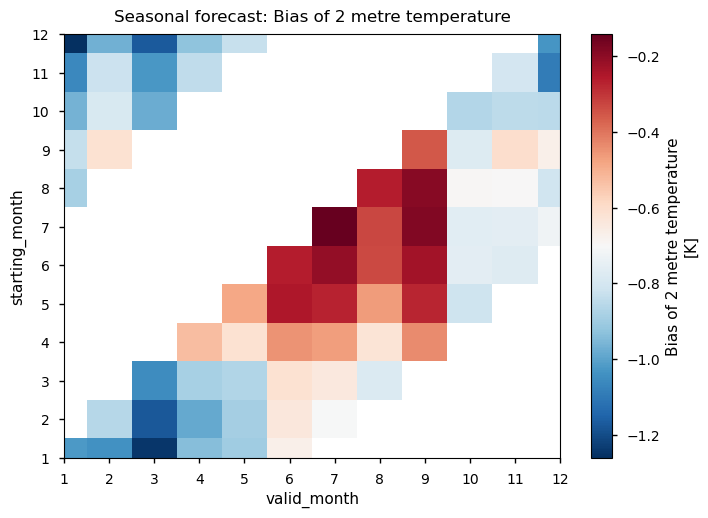

In [15]:
ax = bias["2m_temperature"].sel(centre="ecmwf",region="MED").plot(x="valid_month",cmap="RdBu_r")
_ = plt.title(f"Seasonal forecast: {bias['2m_temperature'].attrs['long_name']}", y=1.01)

## Bias tables

The tables below we summarize the monthly bias for all originating centres (columns) and for all selected areas (rows)

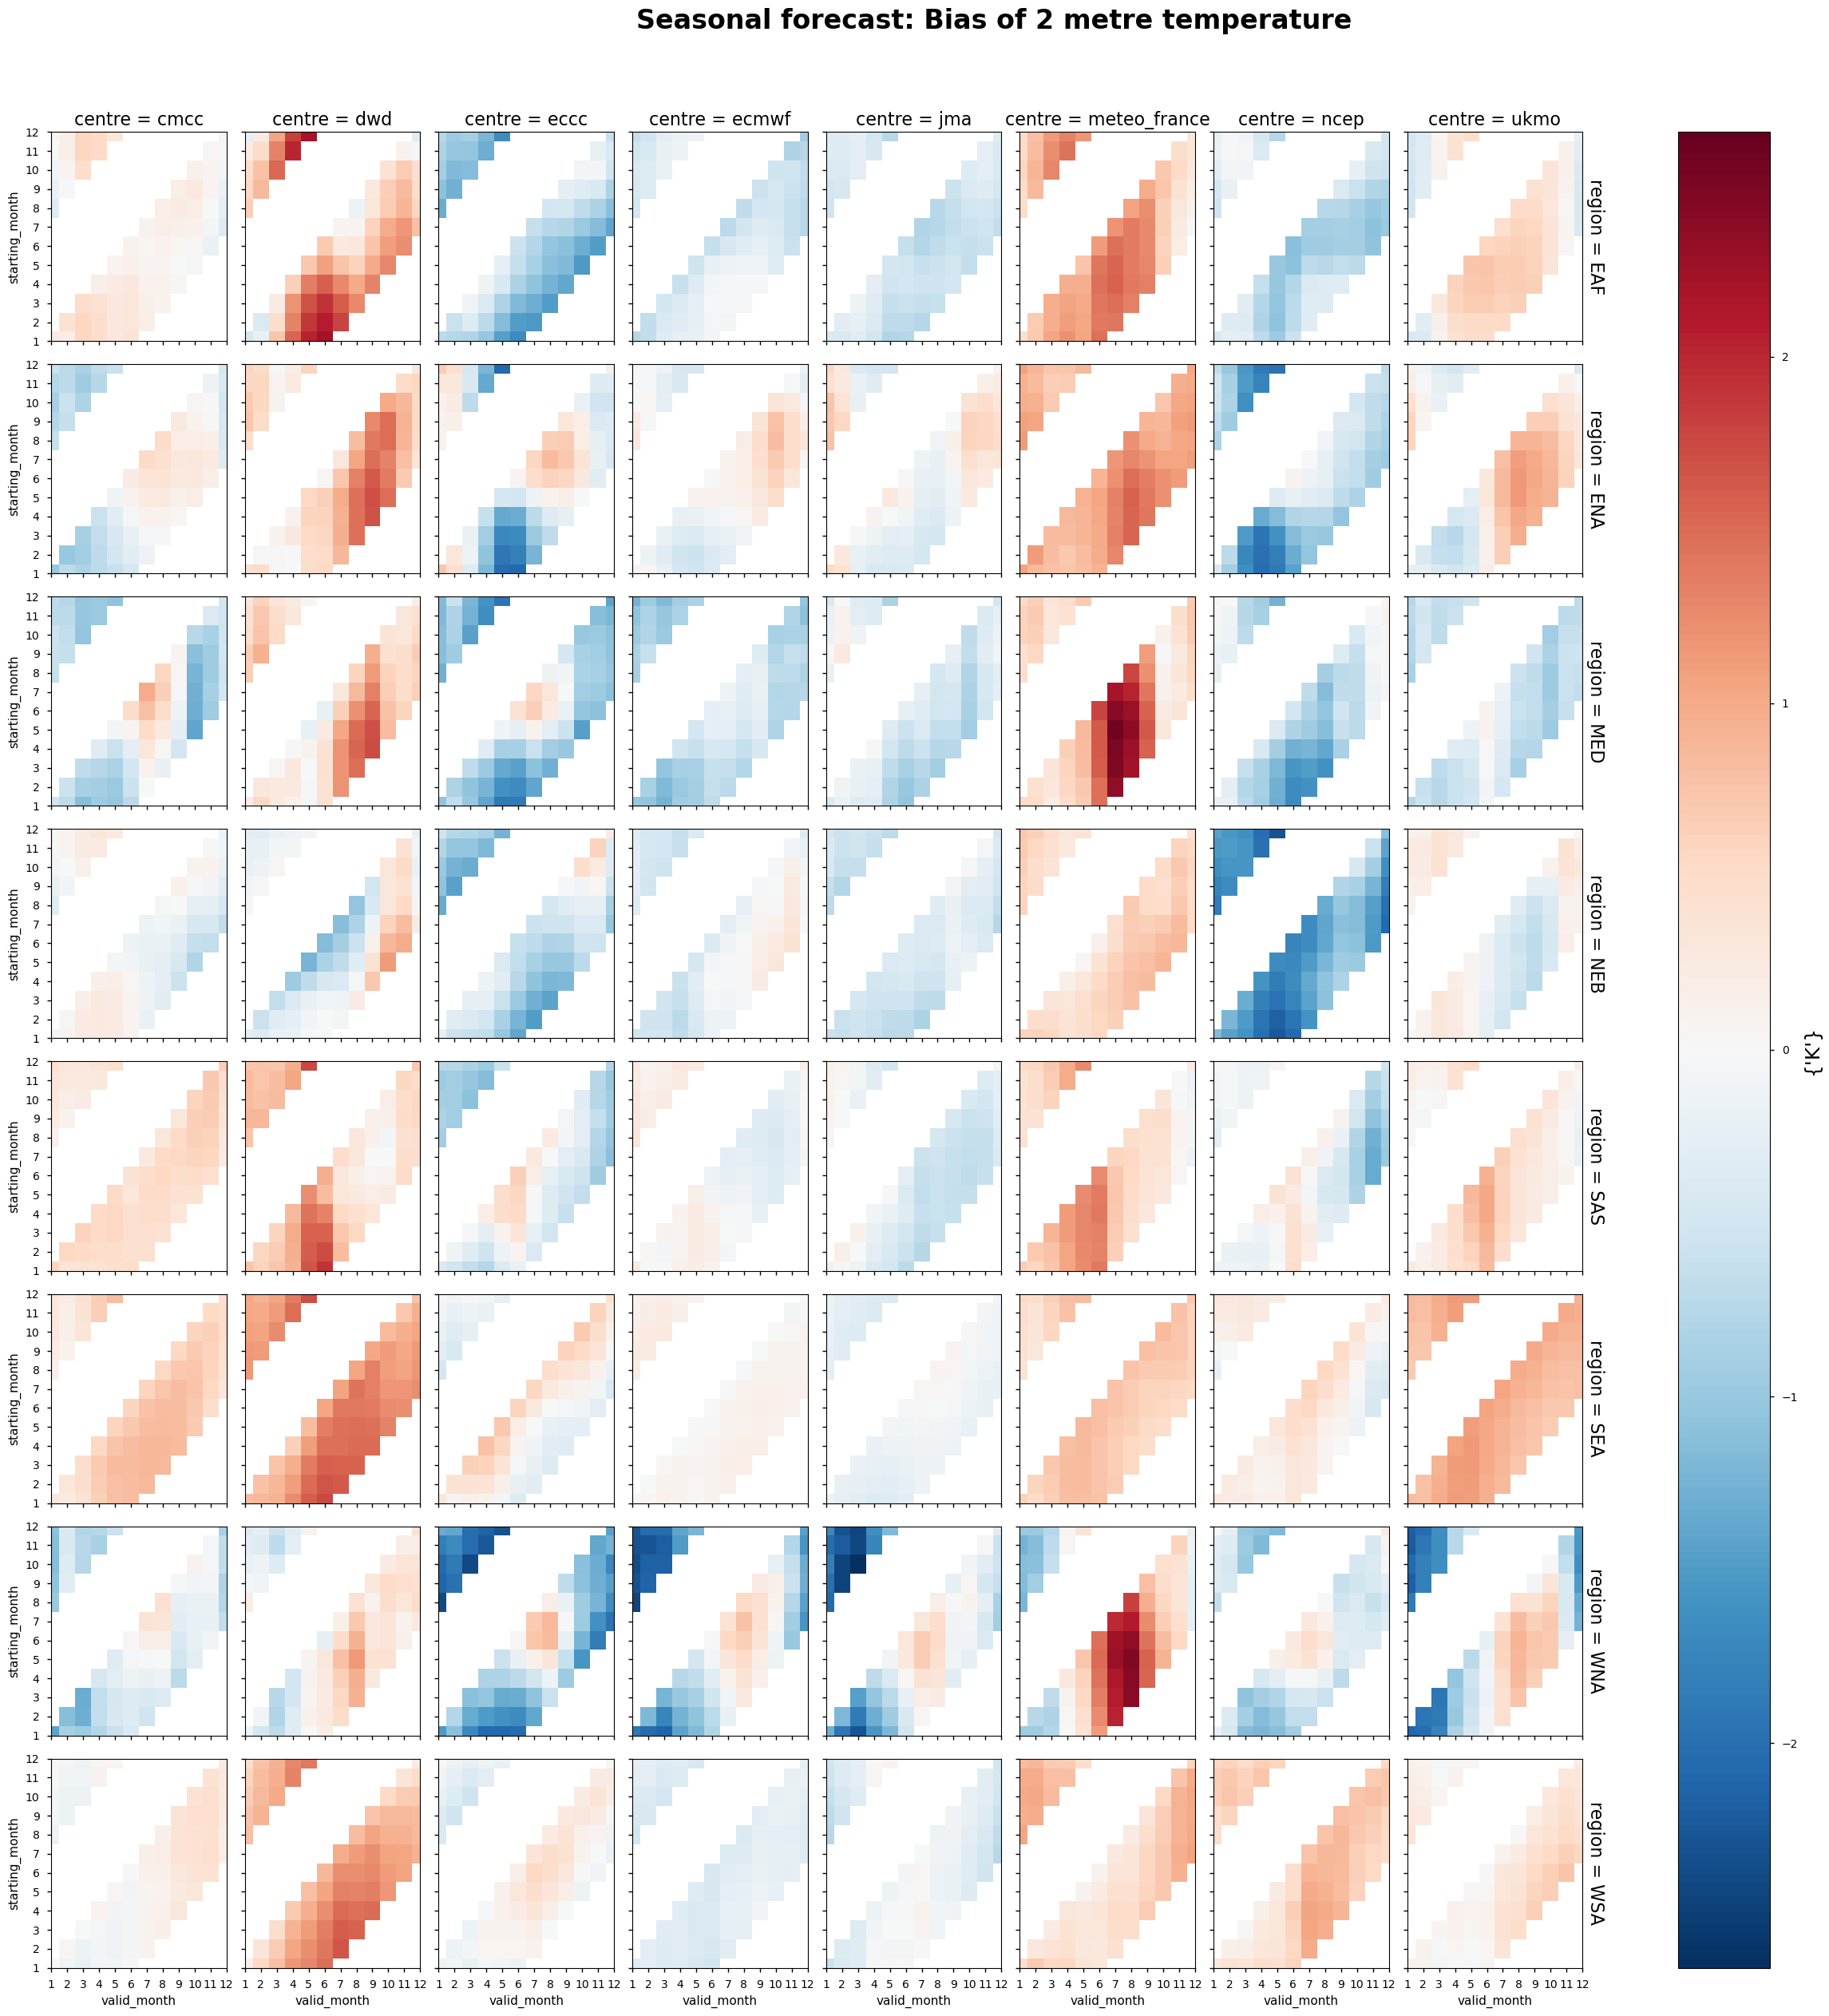

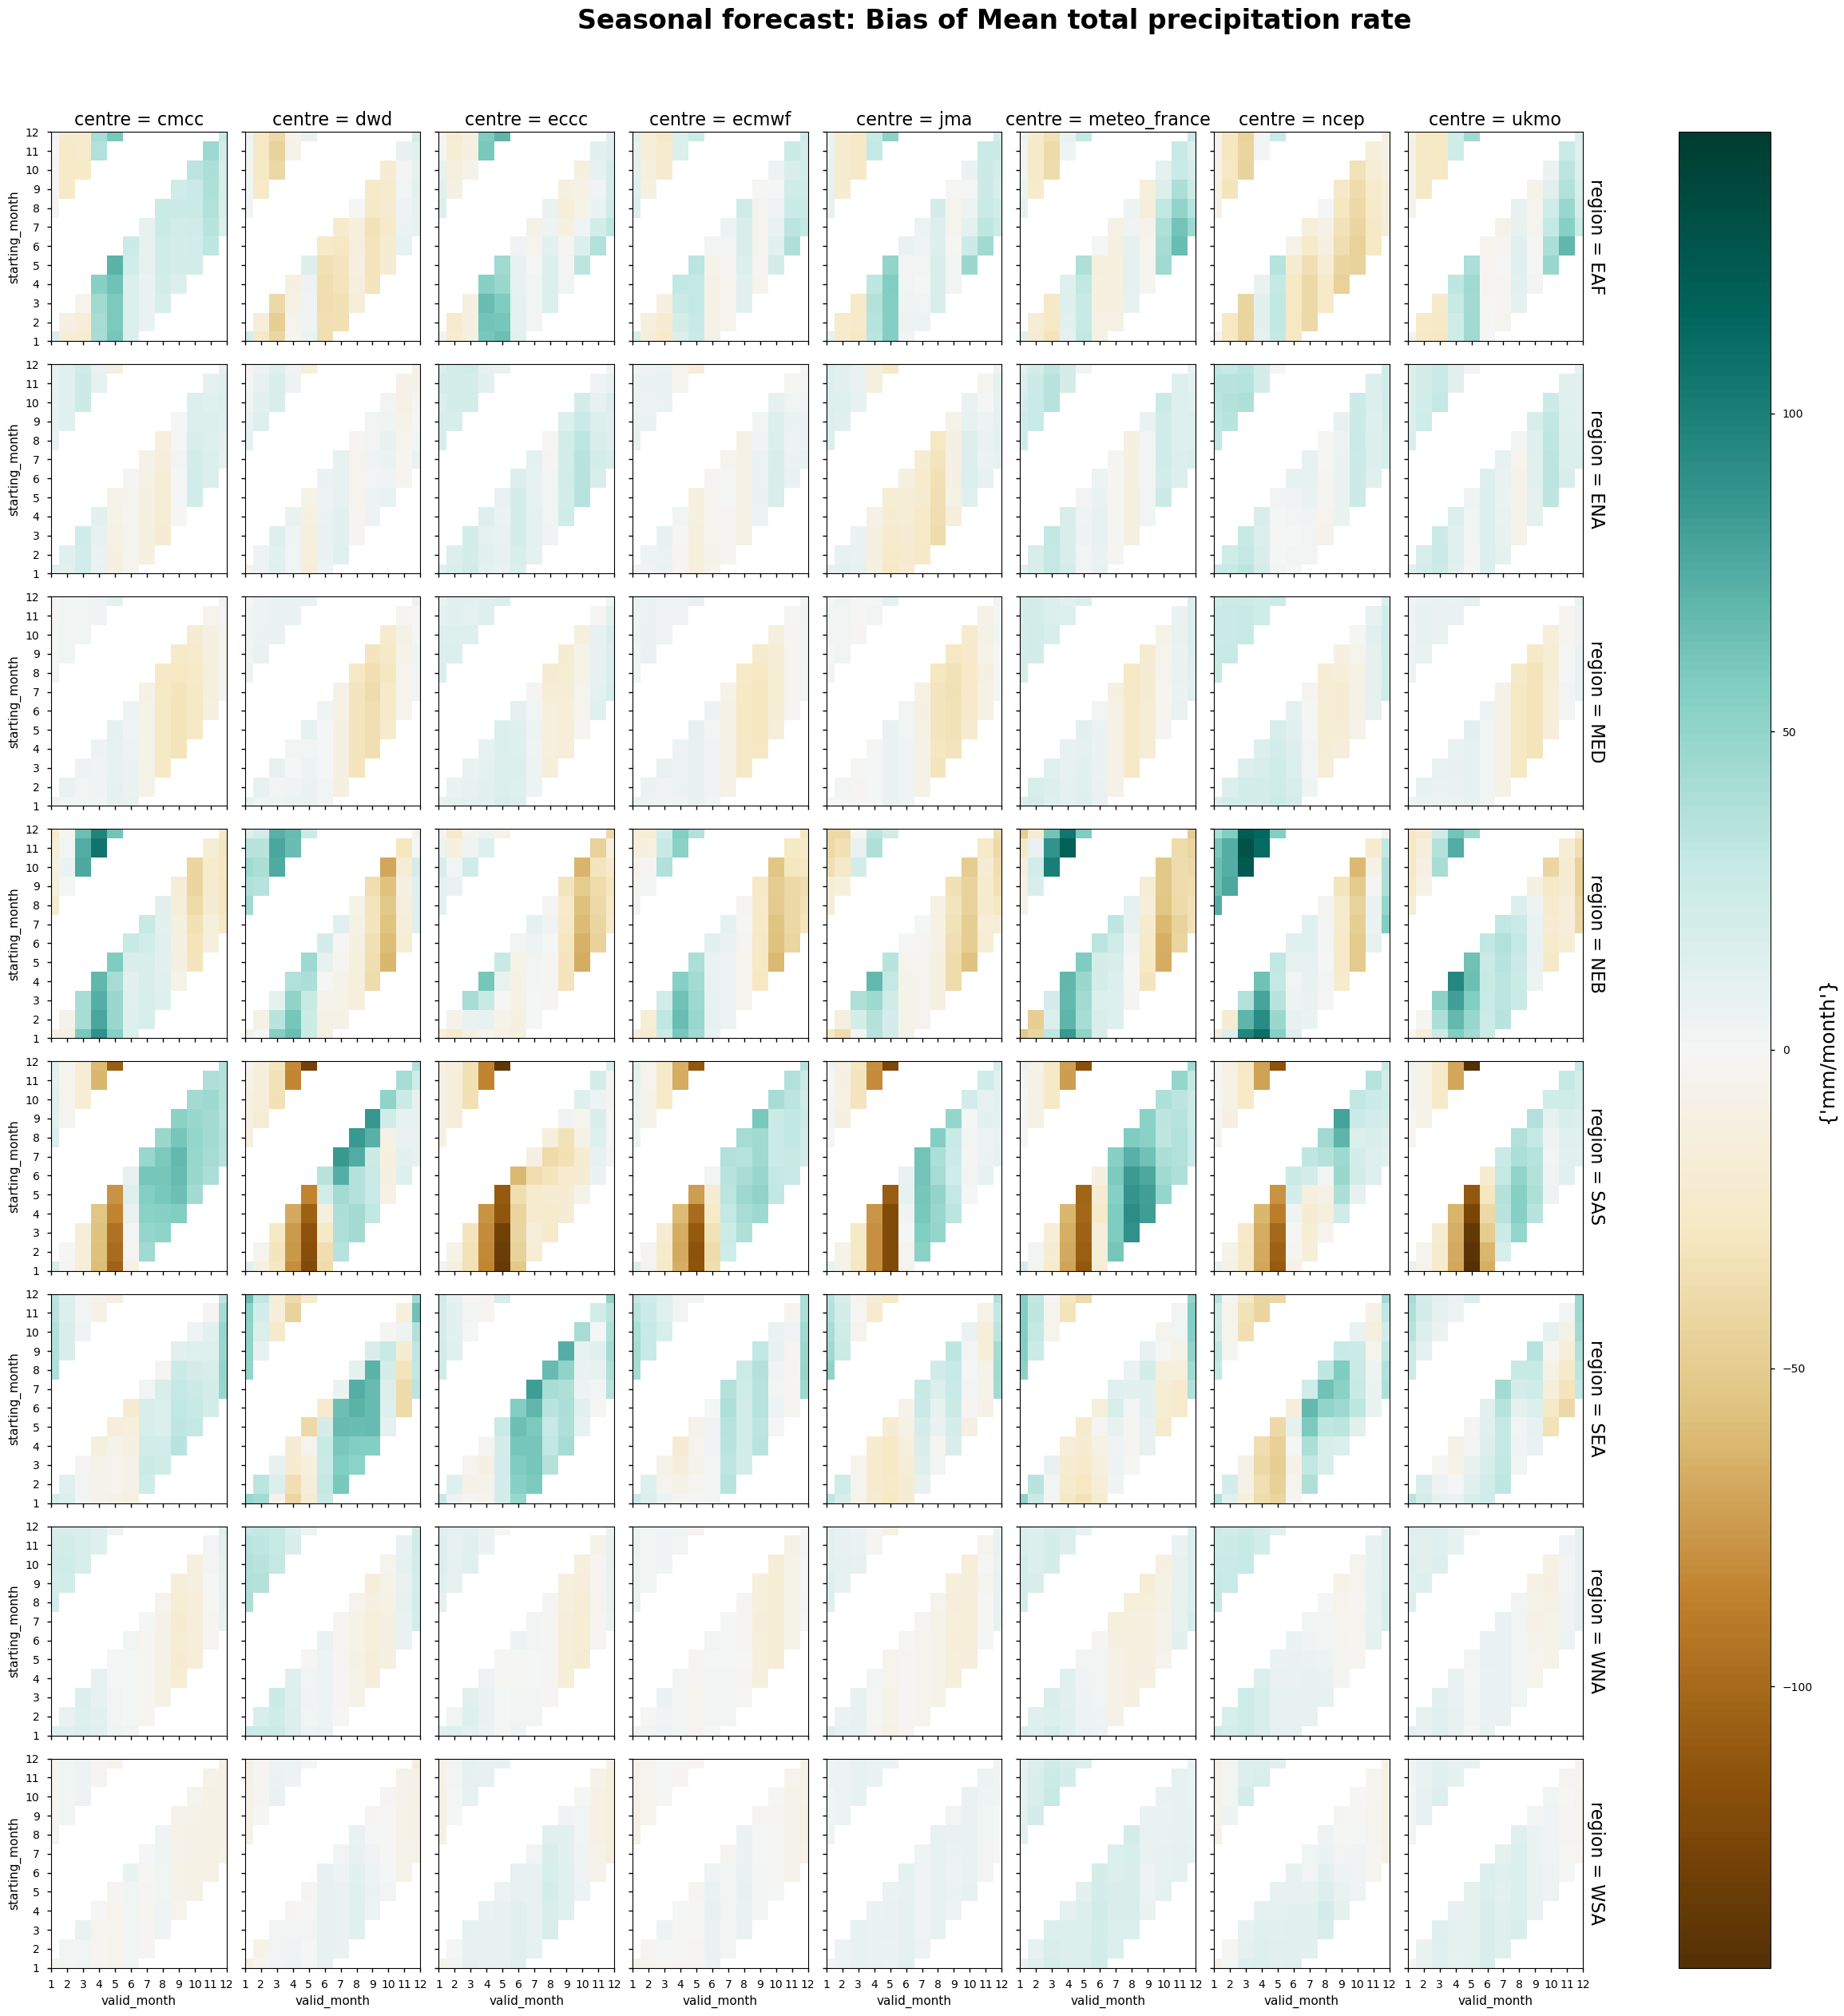

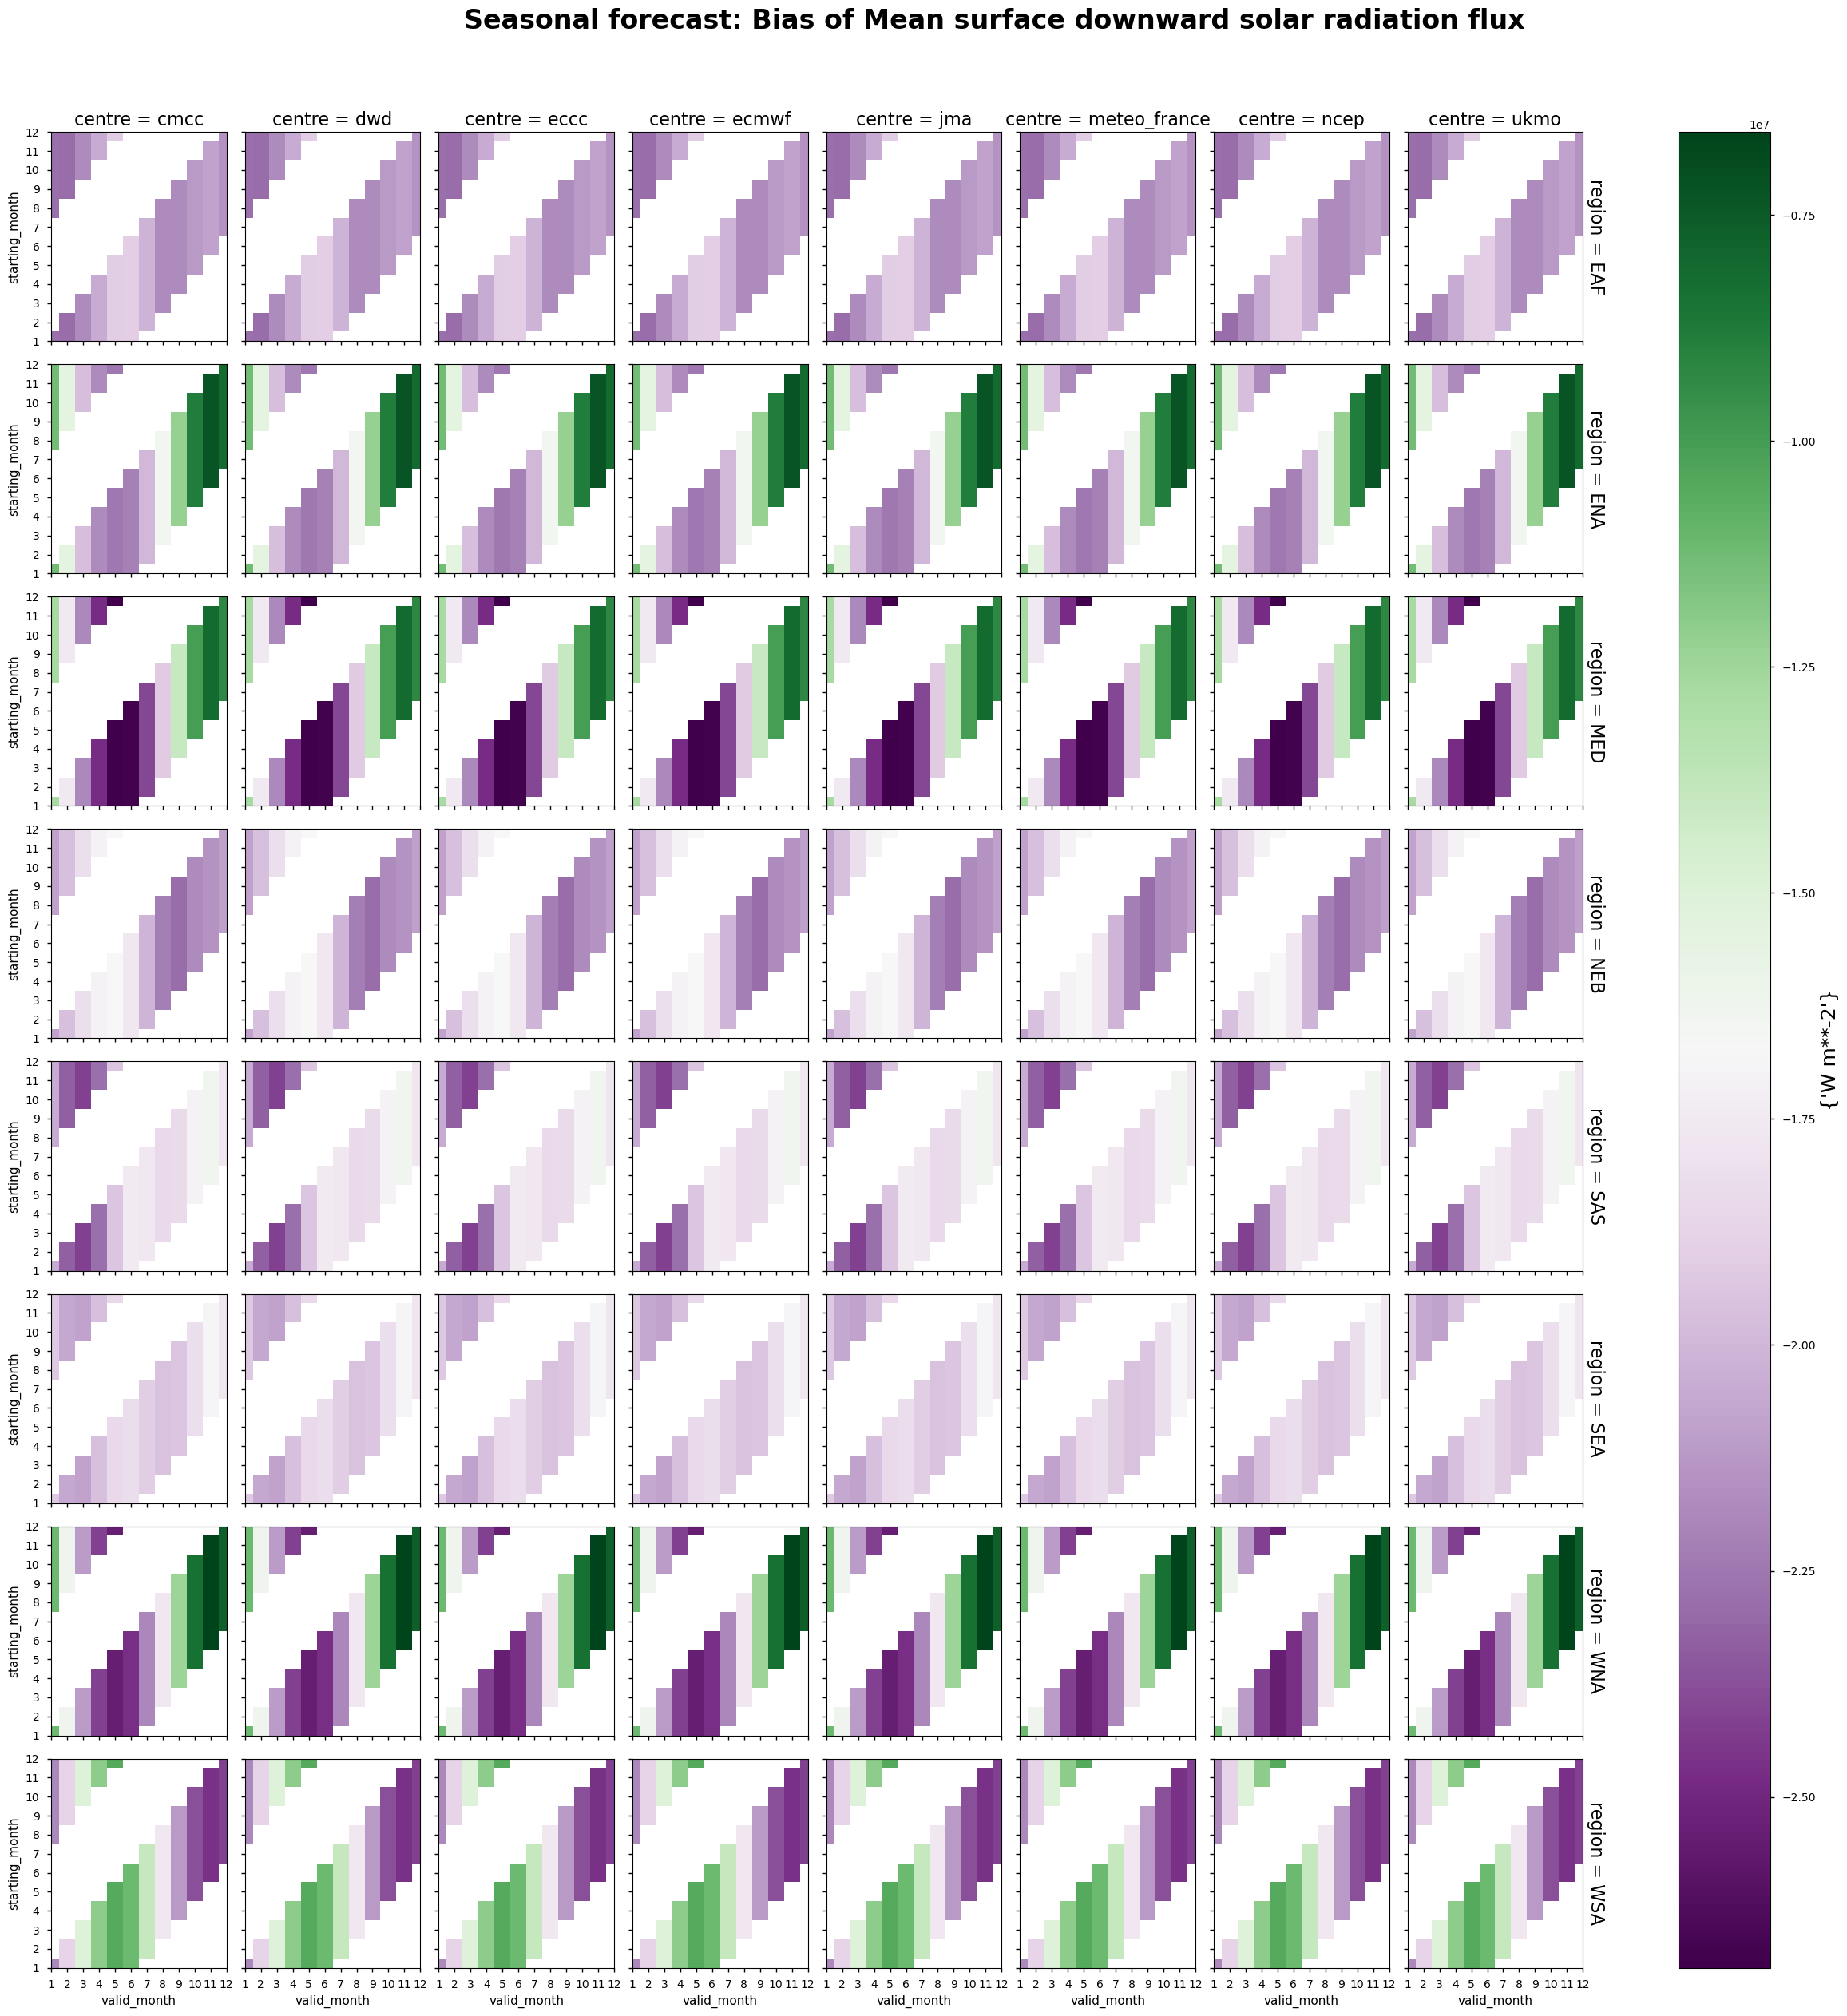

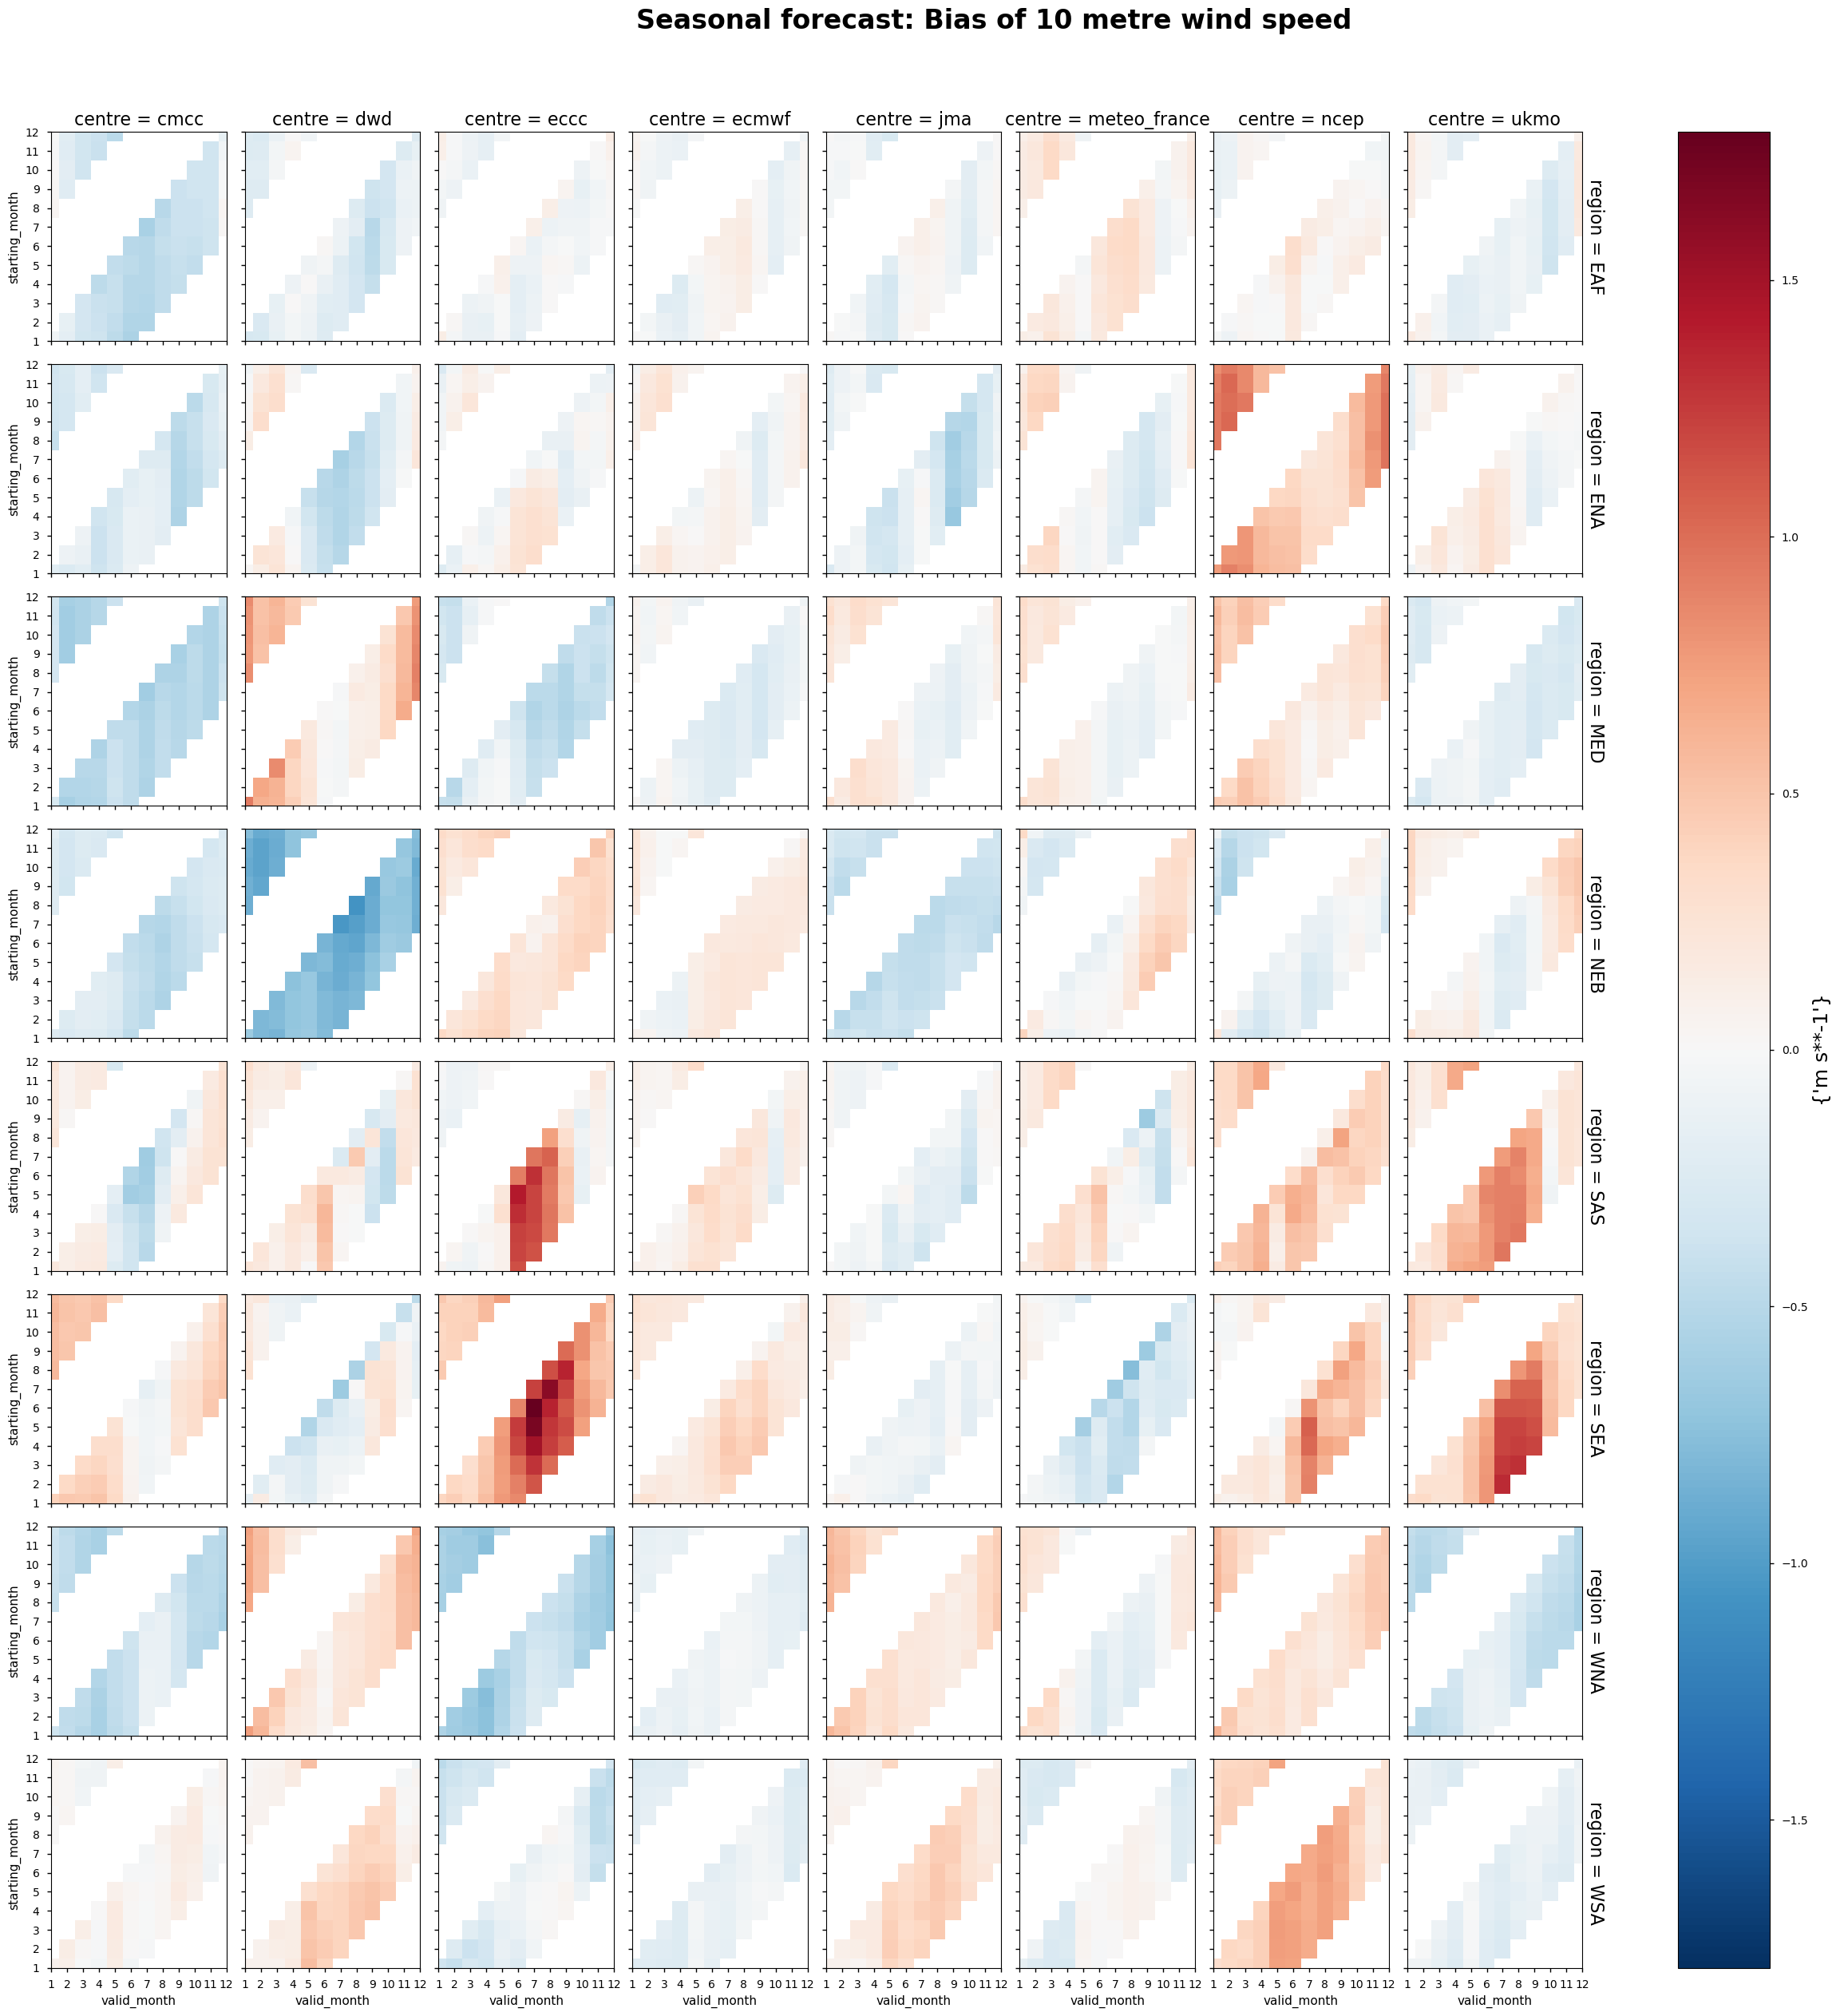

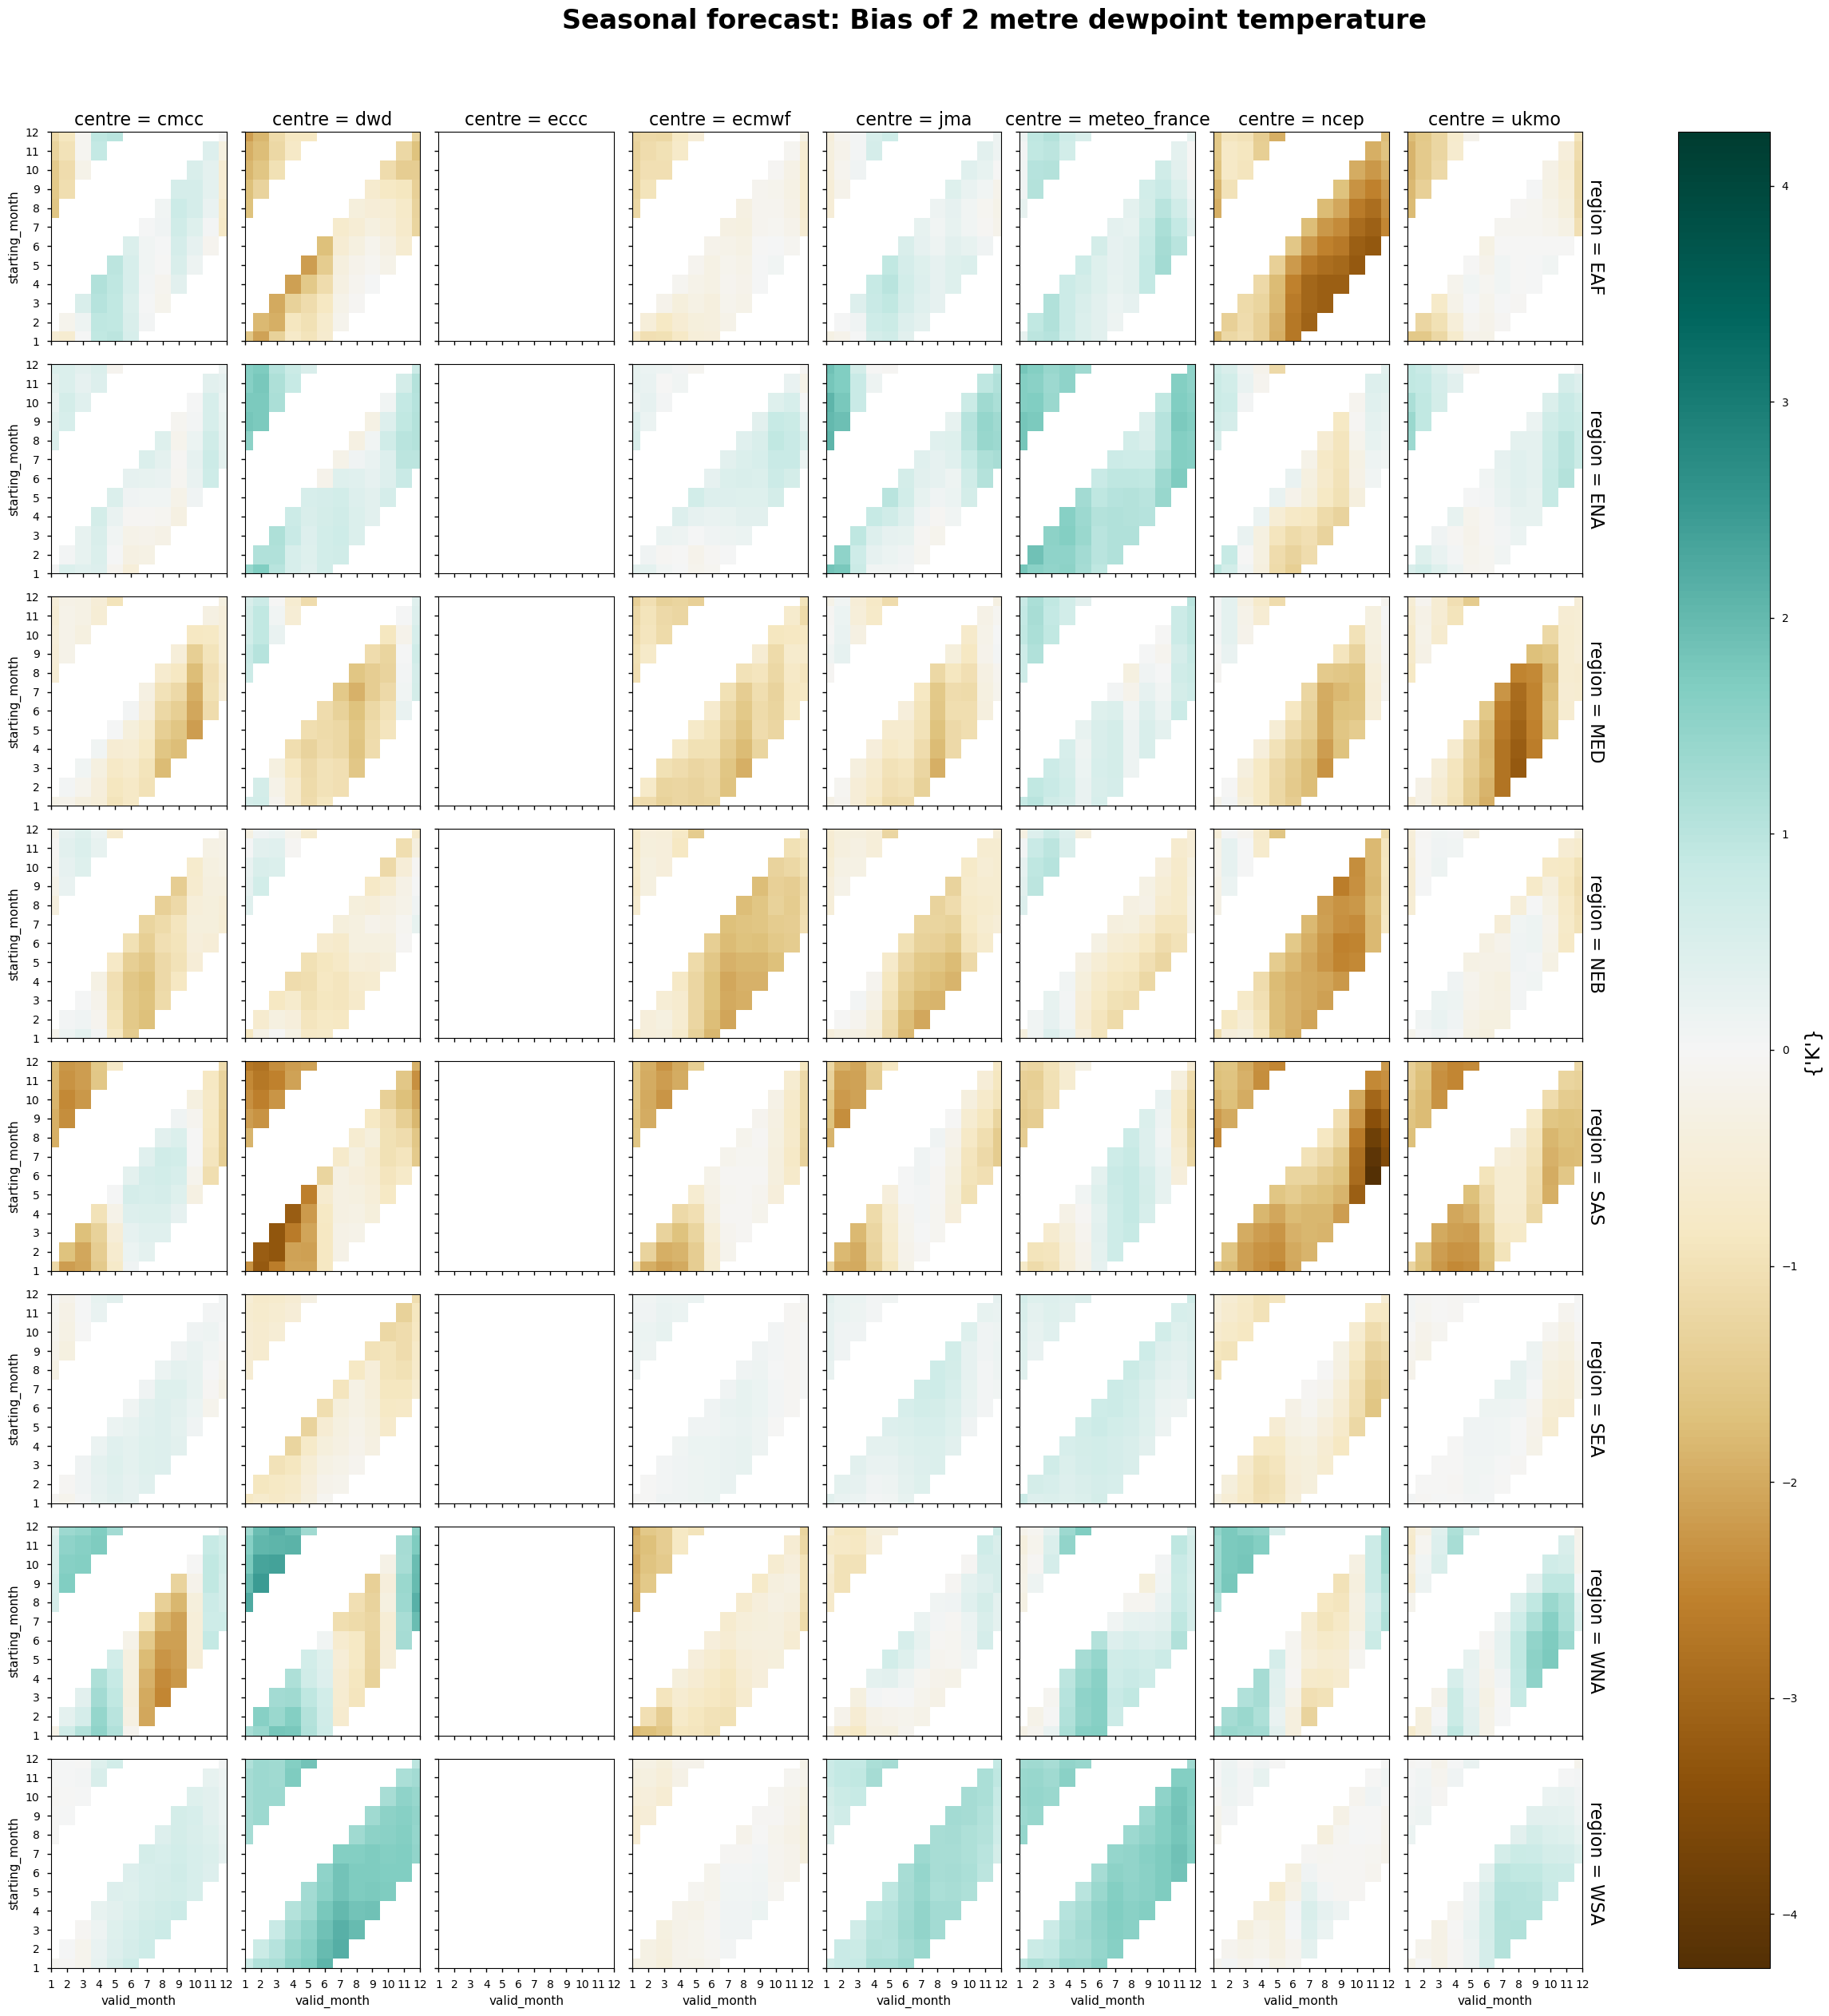

In [16]:
plot_kwargs = {
    "2m_temperature": {"cmap": "RdBu_r"},
    "total_precipitation": {"cmap": "BrBG"},
    "10m_u_component_of_wind": {"cmap": "PuOr"},
    "10m_v_component_of_wind": {"cmap": "PuOr"},
    "2m_dewpoint_temperature": {"cmap": "BrBG"},
    "surface_solar_radiation_downwards": {"cmap": "PRGn"},
}

for varname, da in bias.data_vars.items():
    facet = da.plot(
        col="centre", row="region", x="valid_month", **plot_kwargs.get(varname, {})
    )
    _ = facet.fig.suptitle(f"Seasonal forecast: {da.attrs['long_name']}", y=1.05, fontsize=24, fontweight='bold')
    _ = facet.set_titles(fontsize=16)
    _ = facet.cbar.set_label({da.attrs['units']}, fontsize=18)
    plt.show()

### Main results

**Temperature** - All seasonal forecast models produce significant temperature bias over most of the regions selected for the analysis.  Two centres, DWD and METEOFRANCE, produce a forecast with a prevalent warm bias over most regions and over all seasons.  The temperature bias is a function of both the starting time and of the valid time of the forecast, with a slighlty stronger dependence on the valid time. Therefore the bias does not increase with the leading time of the forecast. Instead, it tends to be a characteristic aspect of each model over the specific region and time of the year. The seasonal cycle of the bias is particularly evident over Western North America.

**Precipitation** - As for the case of temperature, the rainfall bias tends to have a stronger dependance on the valid time of the forecasts. The regions with the larger systematic bias are North-Eastern Brazil and Southern Asia, where all models tend to overestimate the amplitude of the seasonal cycle.

**Wind speed** - Differently from temperature and precipitation, the bias of wind speed does not show a significant seasonal cycle over most of the selected regions. The only exceptions are North-Eastern Brazil and Southern Asia, where some modeles (i.e. ECCC and NCEP) show a positive bias during the months from June to September.

**Dew point temperature** - As for the case of wind speed, the bias of dew point temperature tends to have a weaker seasonal cycle than temperature and precipitation. However some regions (Southern Asia and Western North America) show a slightly stronger dependence seasonal dependence on the bias. NOTE: that dew point temperature is not available for ECCC.

## References

Dainelli, R., Calmanti, S., Pasqui, M., Rocchi, L., Di Giuseppe, E., Monotti, C., ... & Toscano, P. (2022). Moving climate seasonal forecasts information from useful to usable for early within-season predictions of durum wheat yield. Climate Services, 28, 100324.

Jha, P. K., Athanasiadis, P., Gualdi, S., Trabucco, A., Mereu, V., Shelia, V., & Hoogenboom, G. (2019). Using daily data from seasonal forecasts in dynamic crop models for yield prediction: A case study for rice in Nepal’s Terai. Agricultural and forest meteorology, 265, 349-358.

Manzanas, R., Gutiérrez, J. M., Bhend, J., Hemri, S., Doblas-Reyes, F. J., Torralba, V., ... & Brookshaw, A. (2019). Bias adjustment and ensemble recalibration methods for seasonal forecasting: a comprehensive intercomparison using the C3S dataset. Climate Dynamics, 53, 1287-1305.

Rodriguez, D., De Voil, P., Hudson, D., Brown, J. N., Hayman, P., Marrou, H., & Meinke, H. (2018). Predicting optimum crop designs using crop models and seasonal climate forecasts. Scientific reports, 8(1), 2231.



